<a href="https://colab.research.google.com/github/hangjoni/food_classifier_project/blob/main/v2_Food_Classifier_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook setup

In [1]:
from packaging import version
import IPython, ipykernel
if version.parse(IPython.__version__) <= version.parse("5.5.0"):
    !pip install -q --upgrade ipython
    !pip install -q --upgrade ipykernel

    import os
    import signal
    os.kill(os.getpid(), signal.SIGTERM)
print(f"ipykernel=={ipykernel.__version__}")
print(f"IPython=={IPython.__version__}")

ipykernel==6.15.1
IPython==7.34.0


In [2]:
! pip install ipyexperiments
from ipyexperiments import IPyExperimentsCPU, IPyExperimentsPytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.3 MB/s 


In [3]:
# loading necessary library
! pip install timm
! [ -e /content ] && pip install -Uqq fastbook
! pip install kaggle

import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 4.1 MB/s 
     |████████████████████████████████| 719 kB 4.1 MB/s 
     |████████████████████████████████| 1.2 MB 66.5 MB/s 
     |████████████████████████████████| 4.7 MB 49.9 MB/s 
     |████████████████████████████████| 365 kB 16.7 MB/s 
     |████████████████████████████████| 101 kB 11.6 MB/s 
     |████████████████████████████████| 141 kB 67.6 MB/s 
     |████████████████████████████████| 212 kB 38.1 MB/s 
     |████████████████████████████████| 596 kB 71.0 MB/s 
     |████████████████████████████████| 127 kB 68.8 MB/s 
     |████████████████████████████████| 6.6 MB 50.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.15.1 which is incomp

In [4]:
# establish location for google drive
from google.colab import drive
path = Path('/content/gdrive/MyDrive/food11')

# load saved creds
f = open(path/'kaggle.json', "r")
creds = f.read()

# loading kaggle
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
cred_path.parent.mkdir(exist_ok=True)
cred_path.write_text(creds)
cred_path.chmod(0o600)
from kaggle import *

In [5]:
food101 = untar_data("http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz")

In [6]:
food_101_images = food101/'images'
ten = np.random.choice(food_101_images.ls(), 10, replace=False)

In [7]:
for food in ten:
  name = RegexLabeller(fr'./(\w+)$')(food)
  resize_images(food, max_size=224, dest=food101/'food10'/name)

In [8]:
food10 = food101/'food10'
food10.ls()

(#10) [Path('/root/.fastai/data/food-101/food10/strawberry_shortcake'),Path('/root/.fastai/data/food-101/food10/bibimbap'),Path('/root/.fastai/data/food-101/food10/crab_cakes'),Path('/root/.fastai/data/food-101/food10/club_sandwich'),Path('/root/.fastai/data/food-101/food10/macaroni_and_cheese'),Path('/root/.fastai/data/food-101/food10/grilled_cheese_sandwich'),Path('/root/.fastai/data/food-101/food10/pulled_pork_sandwich'),Path('/root/.fastai/data/food-101/food10/peking_duck'),Path('/root/.fastai/data/food-101/food10/lobster_bisque'),Path('/root/.fastai/data/food-101/food10/sashimi')]

# Build our model

In [30]:
def labeller(o):
  return RegexLabeller(fr'.(\w+)/\d+.jpg$')(o)

def train(data, arch, size, item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'), batch_tfms=aug_transforms(size=224, min_scale=0.8), accum=1, epochs=10):
  foods = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=labeller,
    item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
    batch_tfms=aug_transforms(size=224, min_scale=0.8)
  )
  dls = foods.dataloaders(food10, bs=64//accum)
  dls.train.show_batch(max_n=8, nrows=2)
  cbs = GradientAccumulation(64) if accum else []
  learn = vision_learner(dls, arch, metrics=error_rate, cbs=cbs).to_fp16()
  learn.fine_tune(epochs, 0.01)

  valid = learn.dls.valid
  tta_preds, targs = learn.tta(dl=valid)
  tta_error_rate = error_rate(tta_preds, targs)
  
  return learn, learn.tta(dl=dls.valid)



num class:  10


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.413578,0.269003,0.067000,02:04


epoch,train_loss,valid_loss,error_rate,time
0,0.234939,0.276649,0.068000,03:57
1,0.165561,0.166566,0.047000,03:57
2,0.085308,0.165318,0.040500,03:57


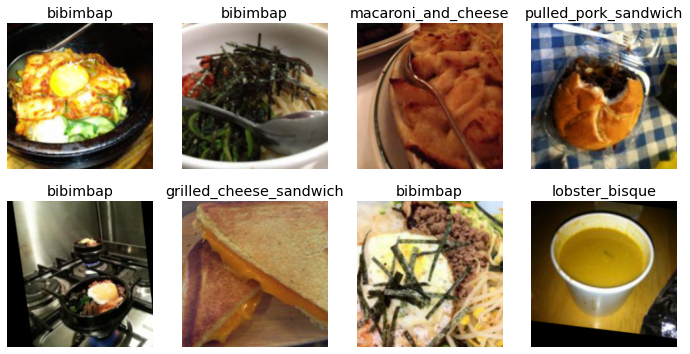

In [28]:
learn, valid_err =train(food10, 'convnext_small_in22k', 224, epochs=3)

In [29]:
learn, valid_err =train(food10, 'convnext_small_in22k', 224, epochs=3)

(TensorBase([[1.8454e-13, 9.3502e-11, 5.0223e-13,  ..., 1.5563e-12, 4.7705e-11, 1.0000e+00],
             [1.6743e-13, 1.8154e-15, 1.3189e-11,  ..., 4.2811e-13, 2.0680e-14, 7.8176e-12],
             [4.2217e-06, 3.0008e-05, 8.2194e-06,  ..., 2.3094e-07, 9.9831e-01, 1.7798e-08],
             ...,
             [4.8404e-06, 6.7092e-05, 5.0798e-05,  ..., 9.9951e-01, 6.0961e-07, 4.0802e-06],
             [5.0337e-09, 4.9870e-09, 1.0000e+00,  ..., 5.7779e-08, 1.6605e-09, 1.0225e-08],
             [9.8276e-09, 1.2042e-07, 1.5244e-08,  ..., 1.3411e-08, 8.6981e-09, 1.4601e-08]]),
 tensor([9, 5, 8,  ..., 7, 2, 4]))